In [10]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

In [7]:
# from objects import RouteManager, EventManager
# route = RouteManager()
# event = EventManager()
# event.start_vehicles(route)
# route.load_all_pax()

In [6]:
# for stop in route.stops['out']:
#     n_pax = []
#     for dest in stop.inactive_pax_arrival_times:
#         n_pax.append(len(dest))
#     print(n_pax)
    # print(stop.inactive_pax_arrival_times)
    

In [8]:
# route.stops['out'][2].inactive_pax_arrival_times

### all scenarios

In [15]:
tstamp = '1023-161248'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
create_field_from_state_item(state, 4, 'delay')
create_field_from_state_item(state, 1, 'n_requests')

In [16]:
## get evolution of delay overtime by scenario with 30 minute buckets
delay_interval = 30*60 # 30 minutes
tmp_trips = trips[['scenario', 'arrival_time', 'delay']].copy()
tmp_trips['bucket'] = tmp_trips['arrival_time'] // delay_interval
## remove maximum bucket
tmp_trips = tmp_trips[tmp_trips['bucket'] < MAX_TIME_HOURS*3600 // delay_interval]

In [17]:
tmp_trips

,scenario,arrival_time,delay,bucket
0,ND,0.0,0.0,0.0
1,ND,139.0,-11.0,0.0
2,ND,348.0,48.0,0.0
3,ND,465.0,15.0,0.0
4,ND,596.0,-4.0,0.0
...,...,...,...,...
23990,DSD,10291.0,-59.0,5.0
23991,DSD,10381.0,-44.0,5.0
23992,DSD,10458.0,-42.0,5.0
23993,DSD,10588.0,-62.0,5.0


In [18]:
pax['bucket'] = pax['arrival_time'] // delay_interval

In [19]:
pax[pax['flex']==1].groupby('bucket').size()

bucket
0.0    1132
1.0    1076
2.0    1110
3.0    1112
4.0    1088
5.0     772
dtype: int64

<AxesSubplot: xlabel='bucket'>

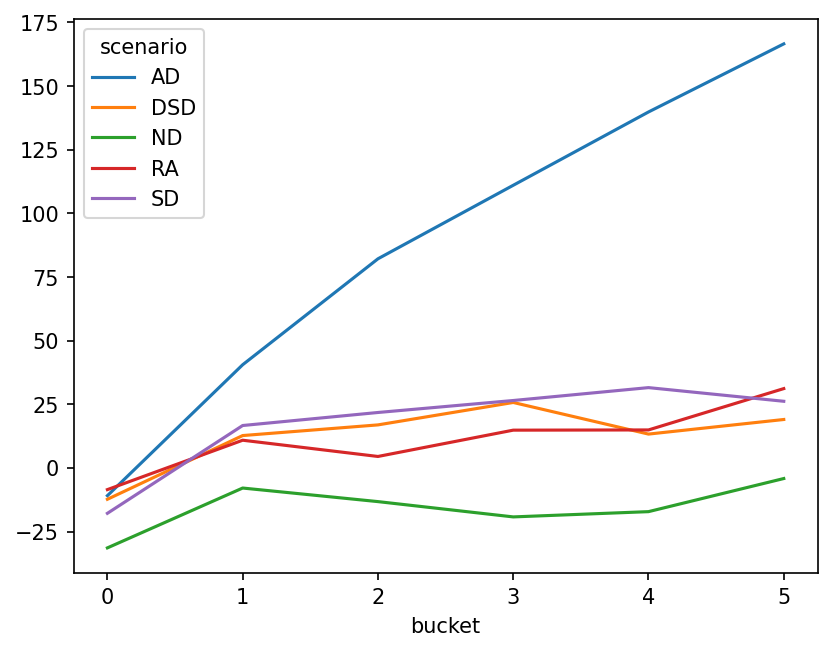

In [20]:
tmp_trips.groupby(['scenario', 'bucket']).agg({'delay': 'mean'}).reset_index().pivot(index='bucket', columns='scenario', values='delay').plot()

### validate parameters

In [21]:
# sns.histplot(state, x='n_requests', hue='scenario')

In [22]:
## expected number of requests at stop 1 and 3 based on inputs
request_rates = [sum(OD_MATRIX[2]), sum(OD_MATRIX[4])]
expected_requests_per_trip = [rr/(60/SCHEDULE_HEADWAY) for rr in request_rates]

## actual requests per trip
total_trip_stops = trips[(trips['stop'].isin(CONTROL_STOPS)) & (trips['scenario']=='DN')].groupby(['direction', 'stop']).size().reset_index().rename(columns={0:'n_trips'})
total_requests = pax[(pax['boarding_time'].isna()) & (pax['scenario']=='DN')].groupby(['direction', 'origin']).size().reset_index().rename(columns={0:'n_requests'})
total_requests['stop'] = total_requests['origin'] - 1
actuals = total_trip_stops.merge(total_requests, on=['direction', 'stop'], how='left')
actuals['requests_per_trip'] = (actuals['n_requests']/actuals['n_trips']).round(2)

In [23]:
def get_n_trips_over_time(data, stop=0, direction='out', scenario='DN'):
    all_trips = data[(data['stop']==stop) & (data['direction']==direction) & (data['scenario']==scenario)].copy()
    all_trips = all_trips.sort_values('arrival_time').reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = all_trips[all_trips['arrival_time']-all_trips['scheduled_time']<(SCHEDULE_TOLERANCE*60)].copy().drop(columns=['count'])

    all_trips = all_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    on_time_trips = on_time_trips.reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = on_time_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    return all_trips, on_time_trips

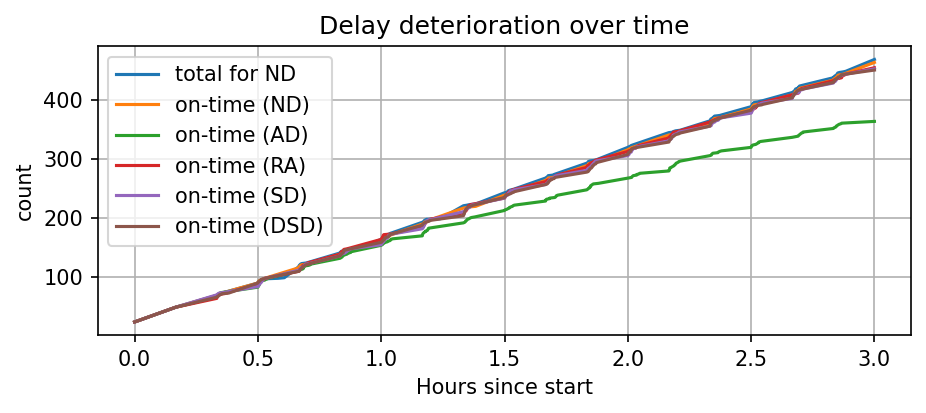

In [24]:
scenarios = ['ND', 'AD', 'RA','SD', 'DSD']
fig, axs = plt.subplots(figsize=(7,2.5))
for i in range(len(scenarios)):
    all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario=scenarios[i])
    all_trips['arrival_time'] = all_trips['arrival_time']/60/60
    on_time_trips['arrival_time'] = on_time_trips['arrival_time']/60/60
    if scenarios[i] == 'ND':
        sns.lineplot(data=all_trips, x='arrival_time', y='count', ax=axs, label='total for ND')
    sns.lineplot(data=on_time_trips, x='arrival_time', y='count', ax=axs, label=f'on-time ({scenarios[i]})')
    axs.set_xlabel('Hours since start')
    axs.set_title('Delay deterioration over time')
    axs.grid(True)

In [25]:
state.groupby(['scenario'])['action'].sum()

scenario
AD     697
DSD    492
ND       0
RA     370
SD     570
Name: action, dtype: int64

In [26]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='ND', flex_stops=FLEX_STOPS)

In [27]:
table

,idle_time,wait_time,headway_cv,load,n_denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips,avg_delay,served_rate
scenario,,,,,,,,,,,
AD,5.29,343.0,0.410,3.23,304,5373,917.0,6290,888,87.0,75.10
DSD,6.26,307.0,0.144,3.14,501,5572,789.0,6361,897,14.0,61.16
ND,12.76,309.0,0.147,2.53,1267,5542,NaN,5542,911,-15.0,NaN
RA,7.97,309.0,0.160,2.93,760,5468,508.0,5976,896,10.0,40.06
SD,5.67,303.0,0.146,3.15,445,5511,799.0,6310,895,20.0,64.23


In [ ]:
fig, axs = plt.subplots(figsize=(3,3))
sns.scatterplot(data=table, x='tot_ridership', y='otp', hue='scenario', ax=axs)
axs.set_xlabel('Total ridership')
axs.set_ylabel('OTP')
axs.axhline(y=80, color='black', linestyle='--')
axs.axvline(x=4200, color='black', linestyle='--')

In [ ]:
table

In [ ]:
table_pcts

In [ ]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

In [ ]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

### adding SG with 1 maximum minutes of delay

In [73]:
tstamp = '1014-163557'
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
create_field_from_state_item(state, 4, 'delay')
create_field_from_state_item(state, 1, 'n_requests')

### validate parameters

In [74]:
# sns.histplot(state, x='n_requests', hue='scenario')

In [75]:
## expected number of requests at stop 1 and 3 based on inputs
request_rates = [sum(OD_MATRIX[2]), sum(OD_MATRIX[4])]
expected_requests_per_trip = [rr/(60/SCHEDULE_HEADWAY) for rr in request_rates]

## actual requests per trip
total_trip_stops = trips[(trips['stop'].isin(CONTROL_STOPS)) & (trips['scenario']=='DN')].groupby(['direction', 'stop']).size().reset_index().rename(columns={0:'n_trips'})
total_requests = pax[(pax['boarding_time'].isna()) & (pax['scenario']=='DN')].groupby(['direction', 'origin']).size().reset_index().rename(columns={0:'n_requests'})
total_requests['stop'] = total_requests['origin'] - 1
actuals = total_trip_stops.merge(total_requests, on=['direction', 'stop'], how='left')
actuals['requests_per_trip'] = (actuals['n_requests']/actuals['n_trips']).round(2)

In [76]:
def get_n_trips_over_time(data, stop=0, direction='out', scenario='DN'):
    all_trips = data[(data['stop']==stop) & (data['direction']==direction) & (data['scenario']==scenario)].copy()
    all_trips = all_trips.sort_values('arrival_time').reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = all_trips[all_trips['arrival_time']-all_trips['scheduled_time']<(SCHEDULE_TOLERANCE/60)].copy().drop(columns=['count'])

    all_trips = all_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    on_time_trips = on_time_trips.reset_index(drop=True).reset_index().rename(columns={'index':'count'})
    on_time_trips = on_time_trips.drop_duplicates(subset=['arrival_time'], keep='last')
    return all_trips, on_time_trips

In [77]:
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='DN')
all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario='FG')

In [ ]:
scenarios = ['ND', 'AD', 'SD']
fig, axs = plt.subplots(figsize=(6,3))
for i in range(len(scenarios)):
    all_trips, on_time_trips = get_n_trips_over_time(trips, stop=0, direction='out', scenario=scenarios[i])
    all_trips['arrival_time'] = all_trips['arrival_time']/60/60
    on_time_trips['arrival_time'] = on_time_trips['arrival_time']/60/60
    if scenarios[i] == 'ND':
        sns.lineplot(data=all_trips, x='arrival_time', y='count', ax=axs, label='total for ND')
    sns.lineplot(data=on_time_trips, x='arrival_time', y='count', ax=axs, label=f'on-time ({scenarios[i]})')
    axs.set_xlabel('Hours since start')
    axs.grid(True)

In [ ]:
state.groupby(['scenario'])['action'].sum()

In [81]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, base_scenario='ND', flex_stops=FLEX_STOPS)

In [ ]:
fig, axs = plt.subplots(figsize=(3,3))
sns.scatterplot(data=table, x='tot_ridership', y='otp', hue='scenario', ax=axs)
axs.set_xlabel('Total ridership')
axs.set_ylabel('OTP')
axs.axhline(y=80, color='black', linestyle='--')
axs.axvline(x=4200, color='black', linestyle='--')

In [ ]:
table

In [ ]:
table_pcts

In [ ]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

In [ ]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [ ]:
event.timestamps[-1]

In [ ]:
pax.groupby(['origin', 'destination']).size().reset_index()

In [ ]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])